Set up the PYTHONPATH so it can find the python modules we'll be using.

In [21]:
import sys, os
sys.path.append(os.path.join(os.path.pardir, 'python'))

Import the geometry module

In [22]:
import geometry as geo

Set the base resolution that will be used throughout

In [23]:
minres = 10.0

For this benchmark we will be declaring a custom constant slope subduction spline. first step is to declare the degrees of freedom along the slab. below are the points along the slab where we are declaring degrees of freedom. 

In [24]:
slab = geo.SlabSpline([0.0, 140.0, 240.0, 400.0], [0.0, -70.0, -120.0, -200.0], 
                       res=[2*minres, 1*minres, 1*minres, 6*minres], sid=1, name="Slab")

  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)



Next we will declare the points along which coupling the wedge begins, which is at 80km and 82.5km depth. this is the point where movement begins in the dynamic wedge. 


In [25]:
# add partial coupling depths
slab.addpoint(80, "Slab::PartialCouplingDepth", res=1*minres)
slab.addpoint(82.5, "Slab::FullCouplingDepth", res=1*minres)


After that we will start describing the geometry of the subduction slab's surrounding area. In this step we will describe the surrounding region and give them an individual region id. We will call the area beneath the slab spline the slab region. this region has a region id, rid=1. next we have the region above the slab. this region is called the wedge and has an id of rid=2. In addition to the regions, each surface is also given an individual id tag. the slabspline is given a surface id of sid=1. the base surface of the slab is given a surface id sid=7, although not shown in the diagram below if needed the wedge base surface is given a surface id sid=8. the left side or the slab side is given a surface id of sid=2. In this manner all surface and regions are given individual tags.

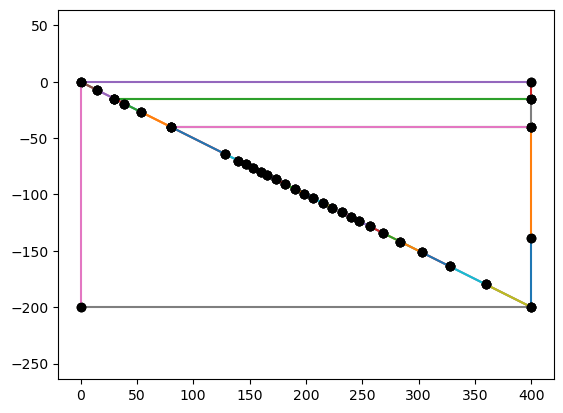

In [26]:
geom = geo.SubductionGeometry(slab, slab_rid=1, wedge_rid=2, 
                                    slab_side_sid=2, wedge_side_sid=3, slab_base_sid=7, 
                                    wedge_base_sid=8, coast_sid=11, top_sid=12,
                                    wedge_top_res=4*minres, slab_base_res=6*minres)
geom.plot()

The next step is adding a crust surface to the geometry. this surface will be called the lower crust and is given region id rid=3. 

['WedgeSide', 'UpperWedgeSide', 'LowerCrust', 'UpperCrust']
8


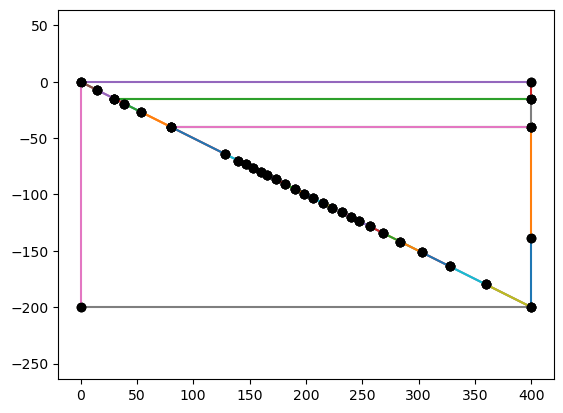

In [27]:
geom.addcrustlayer(40, "LowerCrust", sid=9, rid=3, slab_res=6*minres, side_res=16*minres, slab_sid=13, side_sid=5)
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])
print(len(slab.points))
geom.plot()


Next we divide our crust into two layers, lower crust and upper crust. the lower crust keeps its region id rid=3 and the upper crust is given an rid=4. That finishes declaring all regions surounding the subduction.

['WedgeSide', 'UpperWedgeSide', 'LowerCrust', 'UpperCrust']


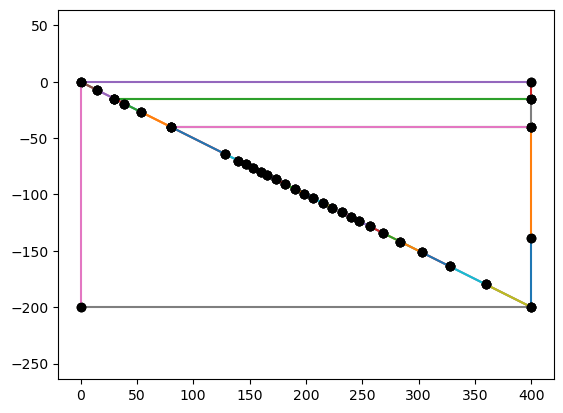

In [28]:
geom.addcrustlayer(15,"UpperCrust", sid=10, rid=4, slab_res= 2*minres, side_res=4*minres, side_sid=6)
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])
geom.plot()


Next we add degrees of freedom along the wedge backarc that separates the inward and outward flow material. the lower side of the wedge is given a surface id of sid=3, whereas the upper side is given an sid=4.

['WedgeSide', 'UpperWedgeSide', 'LowerCrust', 'UpperCrust']


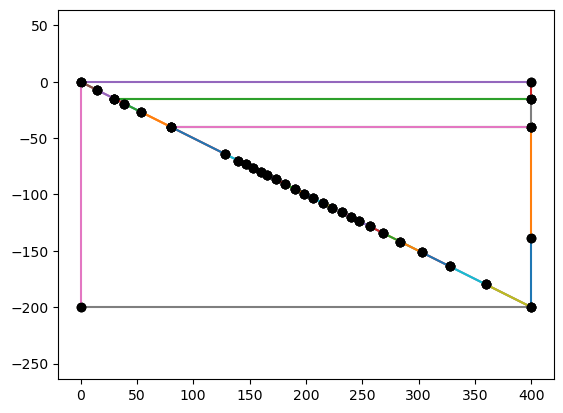

In [29]:
geom.addwedgesidepoint(139, "WedgeSide::InOut", line_name="UpperWedgeSide", res=4*minres, sid=4)
geom.plot()
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])


['WedgeSide', 'UpperWedgeSide', 'LowerCrust', 'UpperCrust']


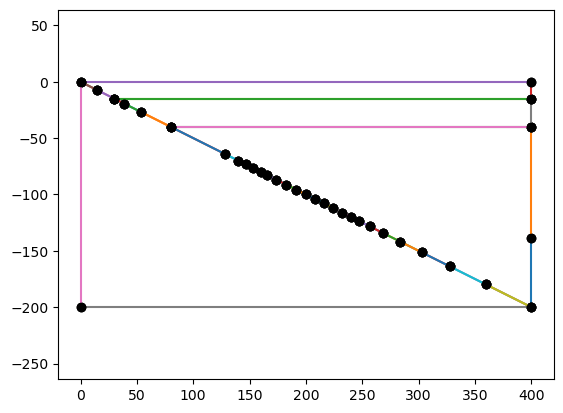

In [30]:
geom.addslabpoint(100, "Slab::DetectorPoint", res=1*minres, sid=1)
geom.plot()
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])


Now that we have finished describing our geometry, we are going to collect all the surface and regions, then generate a mesh. This will be the domain over which we will solve and visualize the subduction.

In [31]:
mesh, ct, ft = geom.generatemesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 70%] Meshing curve 24 (Line)
I

Now that the mesh has been generated below is a visualization of the mesh. each region is separated by its region id.


No module named 'trame'

Falling back to a static output.
  warnings.warn(



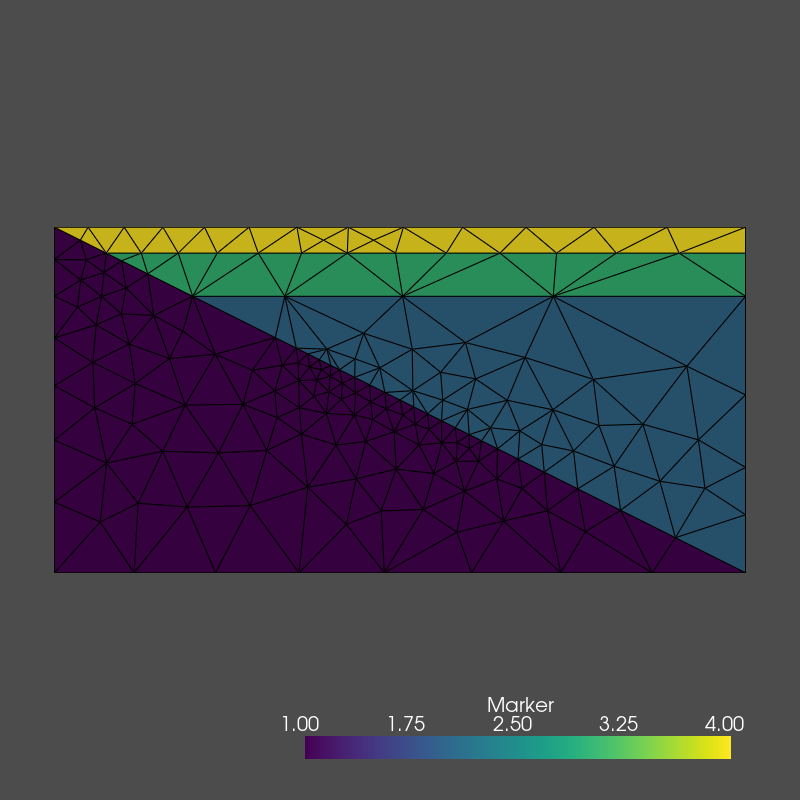

In [32]:
import pyvista
pyvista.start_xvfb()
from dolfinx.plot import create_vtk_mesh
topology, cell_types, x = create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data["Marker"] = ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")

p = pyvista.Plotter(window_size=[800, 800])
p.add_mesh(grid, show_edges=True)
p.view_xy()
p.show()

After generating the mesh, the next thing to do is to declare our function space. Since we have two values that we are solving for we are going to need two separate function spaces. the is described on a stokes equation of velocity and pressure so we need to do two things. the frist is we need a mixed element function space with two sub-function spaces one for velocity and the second one for pressure. Another important point is that this function is going to be a vector function space. However there is one issue regarding solving for velocity. velocity inside the slab region and velocity inside the wedge region do not behave similarily. Therefore we need two mixed element function spaces Vs and Vw, for the slab region velocity and the wedge region velocity respectively. The final function space is the function space for the temperature solution. since the heat flow across the whole subduction zone region behaves independent of the region it is in, temperature over the entire area is solved over one scalar function space.

In [33]:
import dolfinx
import numpy as np
import ufl
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_geometrical, locate_dofs_topological, form
#Declaring velocity and pressure function spaces in the slab region

#describing the subfunction spaces for velocity and pressure as a vector and finite element sub-function space
Ps2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
Ps1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Ve = FunctionSpace(mesh, Ps2)
Pe = FunctionSpace(mesh, Ps1)
#declaring a mixed element function space of velocity and pressure
THs = Ps2 * Ps1
Vs = FunctionSpace(mesh, THs)

#creating trial and test functions
(v_as, p_as) = ufl.TrialFunctions(Vs)
(v_ts, p_ts) = ufl.TestFunctions(Vs)

#separating the mixed element components of Vs and then separating the 2 components of the velocity vector function space
Vs0, _ = Vs.sub(0).collapse()
Vs00, _ = Vs0.sub(0).collapse()
Vs01, _ = Vs0.sub(1).collapse()
Vs1, _ = Vs.sub(1).collapse()

#Declaring velocity and pressure function spaces in the wedge region

#describing the subfunction spaces for velocity and pressure as a vector and finite element sub-function space

Pw2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
Pw1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Vwe = FunctionSpace(mesh, Pw2)
Pwe = FunctionSpace(mesh, Pw1)
THw = Pw2 * Pw1
Vw = FunctionSpace(mesh, THw)

#creating trial and test functions
(v_aw, p_aw) = ufl.TrialFunctions(Vw)
(v_tw, p_tw) = ufl.TestFunctions(Vw)

#separating the mixed element components of Vw and then separating the 2 components of the velocity vector function space
Vw0, _ = Vw.sub(0).collapse()
Vw00, _ = Vw0.sub(0).collapse()
Vw01, _ = Vw0.sub(1).collapse()
Vw1, _ = Vw.sub(1).collapse()

#Creating a finite element function space for the temperature 
Vt = FunctionSpace(mesh, (ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)))

#creating a test and trial function for temperature
T_a = ufl.TrialFunction(Vt)
T_t = ufl.TestFunction(Vt)



The next step is collecting the degrees of freedom and catagorizing them. There are two ways to collecting the degrees of freedom. The first is to collect the degreees of freedom along the surface of a region only. This is going to be helpful when setting a boundary condtion along a surface. The second way is collecting the degrees of freedom on each cells in the called region. this is going to be helpful when the boundary condition is imposed along a region in the domain. An important thing to remember when collecting degrees of freedom is the function space in which we are working. If we are going to impose to boundary condition over the velocity function space inside the wedge, the degrees of freedom must be collected in the wedge velocity function space. Another important point to remember is the degrees of freedom must be located upon both function spaces if different boundary conditions on different function spaces is being declared on the same surface or region. 

In [34]:
slab_surface_dofs_Vs0 = dolfinx.fem.locate_dofs_topological((Vs.sub(0), Vs0), 1, np.concatenate((ft.find(1), ft.find(13))))


In [35]:
slab_surface_dofs_Vs1 = dolfinx.fem.locate_dofs_topological((Vs.sub(1), Vs1), 1, np.concatenate((ft.find(1), ft.find(13))))


In [36]:
All_except_slab_dofs_Vs0 = dolfinx.fem.locate_dofs_topological((Vs.sub(0), Vs0), 2, np.concatenate((ct.find(2), ct.find(3), ct.find(4))))

In [37]:
NonSlab_dofs_Vs0_indices = [i for i, dof in enumerate(All_except_slab_dofs_Vs0[0]) if dof not in slab_surface_dofs_Vs0[0]]
NonSlab_dofs_Vs0 = [All_except_slab_dofs_Vs0[i][NonSlab_dofs_Vs0_indices] for i in range(len(All_except_slab_dofs_Vs0))]

In [38]:
All_except_slab_dofs_Vs1 = dolfinx.fem.locate_dofs_topological((Vs.sub(1), Vs1), 2, np.concatenate((ct.find(2), ct.find(3), ct.find(4))))

In [39]:
NonSlab_dofs_Vs1_indices = [i for i, dof in enumerate(All_except_slab_dofs_Vs1[0]) if dof not in slab_surface_dofs_Vs1[0]]
NonSlab_dofs_Vs1 = [All_except_slab_dofs_Vs1[i][NonSlab_dofs_Vs1_indices] for i in range(len(All_except_slab_dofs_Vs1))]

In [40]:
slab_surface_dofs_Vw0 = dolfinx.fem.locate_dofs_topological((Vw.sub(0), Vw0), 1, ft.find(1))

In [41]:
slab_surface_dofs_Vw1 = dolfinx.fem.locate_dofs_topological((Vw.sub(1), Vw1), 1, ft.find(1))

In [42]:
upperWedge_surface_dofs_Vw0 = dolfinx.fem.locate_dofs_topological((Vw.sub(0), Vw0), 1, ft.find(9))

In [43]:
upperWedge_surface_dofs_Vw1 = dolfinx.fem.locate_dofs_topological((Vw.sub(1), Vw1), 1, ft.find(9))

In [44]:
All_except_wedge_dofs_Vw0 = dolfinx.fem.locate_dofs_topological((Vw.sub(0), Vw0), 2, np.concatenate((ct.find(1), ct.find(3), ct.find(4))))

In [45]:
NonWedge_dofs_Vw0_indices = [i for i, dof in enumerate(All_except_wedge_dofs_Vw0[0]) if dof not in slab_surface_dofs_Vw0[0]]
NonWedge_dofs_Vw0 = [All_except_wedge_dofs_Vw0[i][NonWedge_dofs_Vw0_indices] for i in range(len(All_except_wedge_dofs_Vw0))]


In [46]:
All_except_wedge_dofs_Vw1 = dolfinx.fem.locate_dofs_topological((Vw.sub(1), Vw1), 2, np.concatenate((ct.find(1), ct.find(3), ct.find(4))))

In [47]:
NonWedge_dofs_Vw1_indices = [i for i, dof in enumerate(All_except_wedge_dofs_Vw1[0]) if dof not in slab_surface_dofs_Vw1[0]]
NonWedge_dofs_Vw1 = [All_except_wedge_dofs_Vw1[i][NonWedge_dofs_Vw1_indices] for i in range(len(All_except_wedge_dofs_Vw1))]


In [48]:
NonWedgeTop_dofs_Vw1_indices = [i for i, dof in enumerate(NonWedge_dofs_Vw1[0]) if dof not in upperWedge_surface_dofs_Vw1[0]]
NonWedgeTop_dofs_Vw1 = [NonWedge_dofs_Vw1[i][NonWedgeTop_dofs_Vw1_indices] for i in range(len(NonWedge_dofs_Vw1))]


In [49]:
Backarc_dofs_Vt = dolfinx.fem.locate_dofs_topological(Vt, 1, np.concatenate((ft.find(4), ft.find(5), ft.find(6))))

In [50]:
top_surface_dofs_Vt = dolfinx.fem.locate_dofs_topological(Vt, 1, ft.find(12))

In [51]:
Trench_dofs_Vt = dolfinx.fem.locate_dofs_topological(Vt, 1, ft.find(2))

The next step after locating all the important degrees of freedom is to impose the dirichlet boundary conditions on them. however before, describing the dirichlet boundary conditions, it's important to declare all the constant values that will be used in the equations. below we have declared all the constant values we will be using throughut the entire solving process.

In [52]:
from petsc4py.PETSc import ScalarType
import scipy
zd = 97
Ts = 0
Tm = 1350
kc = 0.8064516
erf = scipy.special.erf
h0=1000
H1=0.419354
H2=0.087097
qs=2096774
z1=-15
z2=-40
kc=0.8064516
km=1
q1 = qs-(H1*z1)
q2=q1-H2*(z2-z1)
eta0=dolfinx.fem.Constant(mesh, ScalarType(10**21))
A_disl=28968
invA_disl=dolfinx.fem.Constant(mesh, ScalarType(1/A_disl))
E_o=dolfinx.fem.Constant(mesh, ScalarType(540000))
n=3.5
etamax=dolfinx.fem.Constant(mesh, ScalarType(10**25))
R=dolfinx.fem.Constant(mesh, ScalarType(8.3145))
T0=dolfinx.fem.Constant(mesh, ScalarType(1.0))
v0=dolfinx.fem.Constant(mesh, ScalarType(.023716014/365.25/24/60/60))
e0=dolfinx.fem.Constant(mesh, ScalarType(v0/h0))
nexp = (n-1.)/n


The next step is imposing the dirichlet boundary conditions.

In [53]:
Ttop = Function(Vt)
Ttop.x.set(0.0)
bc_Ttop = dirichletbc(Ttop, top_surface_dofs_Vt)

In [54]:
def T_l(x):
    return Tm*erf(-x[1]/zd) 
Ttrench = Function(Vt)
Ttrench.interpolate(T_l)
bc_trench_Vt = dirichletbc(Ttrench, Trench_dofs_Vt)

In [55]:

def T_backarc(values):
    Tbackarc = np.empty(values.shape[1])
    for i in range(values.shape[1]):
        x = values[:,i]
        if -x[1] >= -15:
            Tbackarc[i] = Ts-(H1*(-x[1]**2)/(2*kc))+(-x[1]*(qs/kc))
        elif -40 < x[1] < -15:
             Tbackarc[i] = ((Ts-(H1*(z1**2)/(2*kc))+((qs/kc)*z1))-(H2*(-x[1]-z1)/2*kc)+(q1*(-x[1]-z1)))
        else:
             Tbackarc[i] = min(Tm,((Ts-(H1*(z2**2)/(2*kc))+((qs/kc)*z2))+q2*(-x[1]-z2)/km))
        #else:
            #TBackarc=Tm
        
    return Tbackarc
TBackarc = Function(Vt)
TBackarc.interpolate(T_l)


bc_backarc_Vt = dirichletbc(TBackarc, Backarc_dofs_Vt)

In [56]:
zero_vs = Function(Vs0)
zero_vs.x.set(0.0)
bc_NonSlab_Vs0 = dirichletbc(zero_vs, NonSlab_dofs_Vs0, Vs.sub(0))


In [57]:
zero_ps = Function(Vs1)
zero_ps.x.set(0.0)
bc_NonSlab_Vs1 = dirichletbc(zero_ps, NonSlab_dofs_Vs1, Vs.sub(1))


In [58]:
zero_v = Function(Vw0)
zero_v.x.set(0.0)
bc_WedgeTop = dirichletbc(zero_v, upperWedge_surface_dofs_Vw0, Vw.sub(0))


In [59]:
zero_vw = Function(Vw0)
zero_vw.x.set(0.0)
bc_NonWedge_Vw0 = dirichletbc(zero_vw, NonWedge_dofs_Vw0, Vw.sub(0))


In [60]:
zero_pw = Function(Vw1)
zero_pw.x.set(0.0)
bc_NonWedgeTop_Vw1 = dirichletbc(zero_pw, NonWedgeTop_dofs_Vw1, Vw.sub(1))


In [61]:

vo = 0.023716

def slab_velocity_s(values):
    return_values = np.empty((2,values.shape[1]))
    for i in range(values.shape[1]):
        x = values[:,i]
        return_values[:,i] = 0.1*slab.unittangentx(x[0])/vo
    return return_values
Vslab_s = Function(Vs0)
Vslab_s.interpolate(slab_velocity_s)
bc_slab_s = dirichletbc(Vslab_s, slab_surface_dofs_Vs0, Vs.sub(0))


In [62]:

def slab_velocity_w(values):
    return_values = np.empty((2,values.shape[1]))
    cd = 80.0
    vo = 0.023716
    for i in range(values.shape[1]):
        x = values[:,i]
        return_values[:,i] = min(max(-(x[1]+cd)/2.5, 0.0), 1.0)*0.1*slab.unittangentx(x[0])/vo
    return return_values
Vslab_w = Function(Vw0)
Vslab_w.interpolate(slab_velocity_w)
bc_slab_w = dirichletbc(Vslab_w, slab_surface_dofs_Vw0, Vw.sub(0))


When solving for values of velocity independently in each region we are going to need an integration subdomain for each region. below we are describing an integration subdomains dx() over the entire domain. the entry that goes in dx declares the region in which we are solving for  our values.

In [63]:
ds = ufl.Measure('ds', domain=mesh, subdomain_data=ft)
dx = ufl.Measure("dx", domain=mesh, subdomain_data=ct)

In [64]:
from petsc4py.PETSc import ScalarType

zero_c = dolfinx.fem.Constant(mesh, ScalarType(0.0))
Ks = ufl.inner(ufl.sym(ufl.grad(v_ts)), 2*ufl.sym(ufl.grad(v_as)))*dx(1) + zero_c*ufl.inner(v_ts, v_as)*dx
Gs = -ufl.div(v_ts)*p_as*dx(1)
Ds = -p_ts*ufl.div(v_as)*dx(1)
Ss = Ks + Gs + Ds + zero_c*p_ts*p_as*dx

fs = zero_c * v_ts[0] * dx(1)
problem_vs = dolfinx.fem.petsc.LinearProblem(Ss, fs, bcs=[bc_slab_s, bc_NonSlab_Vs1, bc_NonSlab_Vs0], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})
us_i = problem_vs.solve()
vs_i=us_i.sub(0)

In [65]:
from dolfinx import io
vs = us_i.sub(0).collapse()
#v = Vslab_s
vs.name = "Velocity"
ps = us_i.sub(1).collapse()
ps.name = "Pressure"

with io.VTKFile(mesh.comm, "output_v.pvd", "w") as vtk:
    vtk.write_function([vs], 0.0)
with io.VTKFile(mesh.comm, "output_p.pvd", "w") as vtk:
    vtk.write_function([ps], 0.0)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



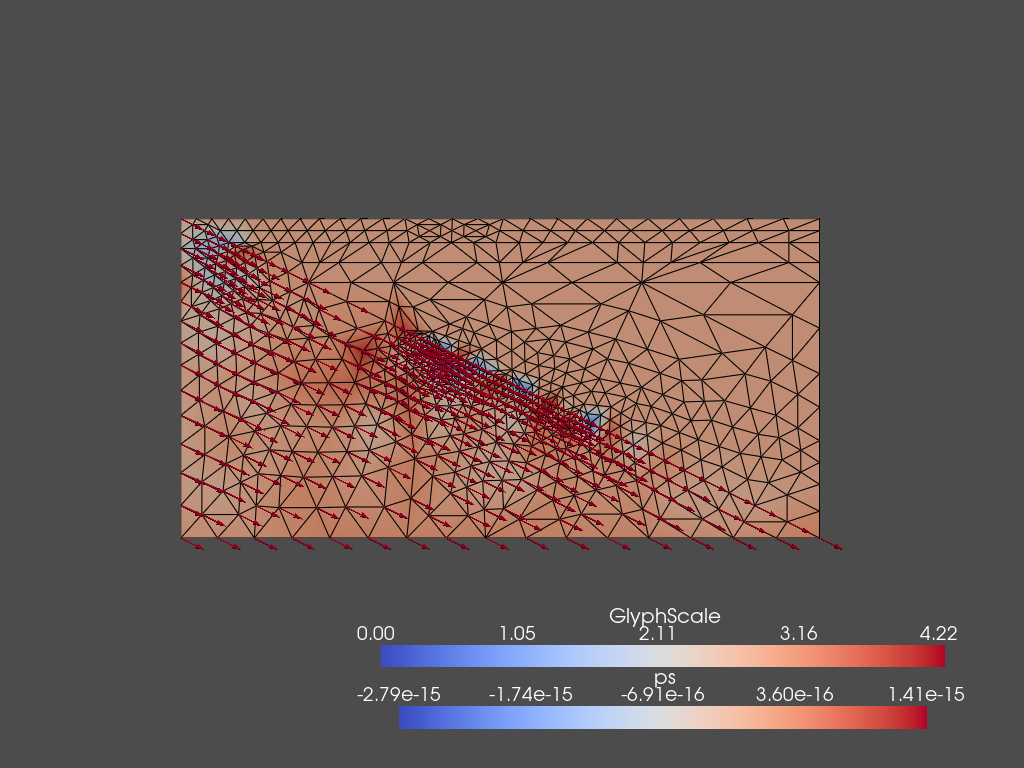

In [66]:
import pyvista
from dolfinx.plot import create_vtk_mesh
import matplotlib.pyplot as plt

pyvista.start_xvfb()
topologys, cell_types_s, geometrys = create_vtk_mesh(Vs0)
values_s = np.zeros((geometrys.shape[0], 3), dtype=np.float64)
values_s[:, :len(vs)] = vs.x.array.real.reshape((geometrys.shape[0], len(vs)))

# Create a point cloud of glyphs
function_grids = pyvista.UnstructuredGrid(topologys, cell_types_s, geometrys)
function_grids["vs"] = values_s
glyphs_s = function_grids.glyph(orient="vs", factor=4)

# create a scalar field on the P2 element
p_p2s = Function(Vs00)
# and interpolate the pressure onto it
p_p2s.interpolate(ps)
# then put that pressure onto the function_grid
function_grids["ps"] = p_p2s.x.array.real
function_grids.set_active_scalars("ps")

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(function_grids, show_edges=True, cmap='coolwarm')
plotter.add_mesh(glyphs_s, cmap='coolwarm')
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.savefig('Vel_Pressurefield2.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [67]:
from petsc4py.PETSc import ScalarType

zero_c = dolfinx.fem.Constant(mesh, ScalarType(0.0))
Kw = ufl.inner(ufl.sym(ufl.grad(v_tw)), 2*ufl.sym(ufl.grad(v_aw)))*dx(2) + zero_c*ufl.inner(v_tw, v_aw)*dx
Gw = -ufl.div(v_tw)*p_aw*dx(2)
Dw = -p_tw*ufl.div(v_aw)*dx(2)
Sw = Kw + Gw + Dw + zero_c*p_tw*p_aw*dx


fw = zero_c * (v_tw[0] + v_tw[1] + p_tw) * dx(2)
problem_vw = dolfinx.fem.petsc.LinearProblem(Sw, fw, bcs=[bc_slab_w, bc_WedgeTop, bc_NonWedge_Vw0, bc_NonWedgeTop_Vw1], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})
uw_i = problem_vw.solve()
vw_i=uw_i.sub(0)

In [68]:
from dolfinx import io
vw = uw_i.sub(0).collapse()
#vw = Vslab_w
vw.name = "Velocityw"
pw = uw_i.sub(1).collapse()
pw.name = "Pressurew"

with io.VTKFile(mesh.comm, "output_vw.pvd", "w") as vtk:
    vtk.write_function([vw], 0.0)
with io.VTKFile(mesh.comm, "output_pw.pvd", "w") as vtk:
    vtk.write_function([pw], 0.0)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



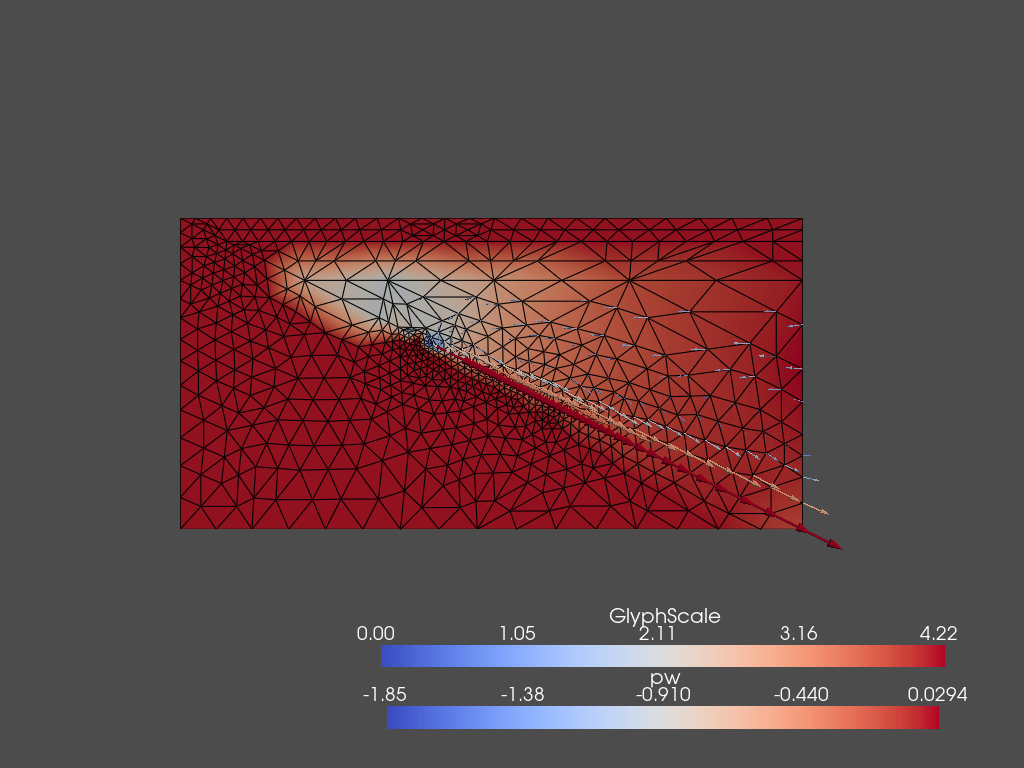

In [69]:
import pyvista
from dolfinx.plot import create_vtk_mesh
import matplotlib.pyplot as plt

pyvista.start_xvfb()
topologyw, cell_typesw, geometryw = create_vtk_mesh(Vw0)
valuesw = np.zeros((geometryw.shape[0], 3), dtype=np.float64)
valuesw[:, :len(vw)] = vw.x.array.real.reshape((geometryw.shape[0], len(vw)))

# Create a point cloud of glyphs
function_gridw = pyvista.UnstructuredGrid(topologyw, cell_typesw, geometryw)
function_gridw["vw"] = valuesw
glyphsw = function_gridw.glyph(orient="vw", factor=7)

# create a scalar field on the P2 element
p_p2w = Function(Vw00)
# and interpolate the pressure onto it
p_p2w.interpolate(pw)
# then put that pressure onto the function_grid
function_gridw["pw"] = p_p2w.x.array.real
function_gridw.set_active_scalars("pw")

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(function_gridw, show_edges=True, cmap='coolwarm')
plotter.add_mesh(glyphsw, cmap='coolwarm')
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.savefig('Vel_Pressurefield2.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [71]:
from ufl import dot,inner,grad,sym

S1 =  (T_t*dot(vs_i, grad(T_a))+inner(grad(T_a), grad(T_t)))*dx(1)
S2 =  (T_t*dot(vw_i, grad(T_a))+inner(grad(T_a), grad(T_t)))*dx(2)
S3 =  (inner(grad(T_a), grad(T_t)))*dx(3)
S4 =  (inner(grad(T_a), grad(T_t)))*dx(4)
St=S1+S2+S3+S4
ft = T_t*H1*dx(4) + T_t*H2*dx(3)

problem_T = dolfinx.fem.petsc.LinearProblem(St, ft, bcs=[bc_Ttop, bc_trench_Vt, bc_backarc_Vt], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
T_i = problem_T.solve()


No module named 'trame'

Falling back to a static output.
  warnings.warn(



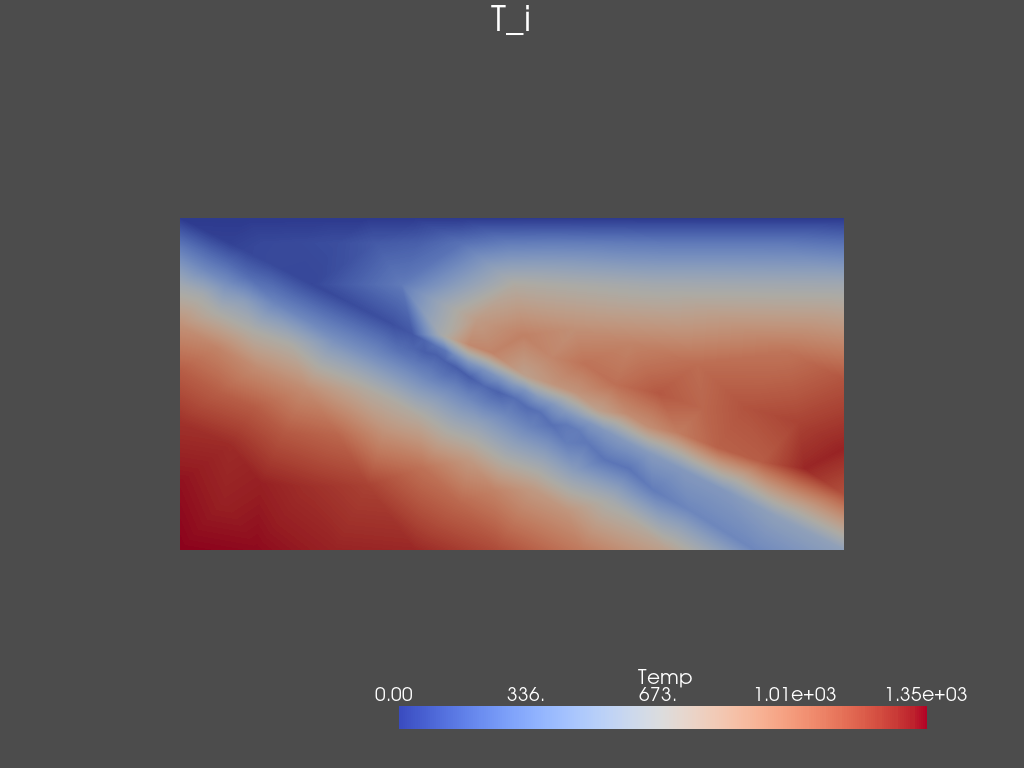

In [72]:
pyvista.start_xvfb()

from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(T_i.function_space)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["Temp"] = T_i.x.array
grid.set_active_scalars("Temp")

plotter = pyvista.Plotter()
plotter.add_text("T_i", position="upper_edge", font_size=14)
plotter.add_mesh(grid, show_edges=False, cmap = 'coolwarm')
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("Temp.pdf")


No module named 'trame'

Falling back to a static output.
  warnings.warn(



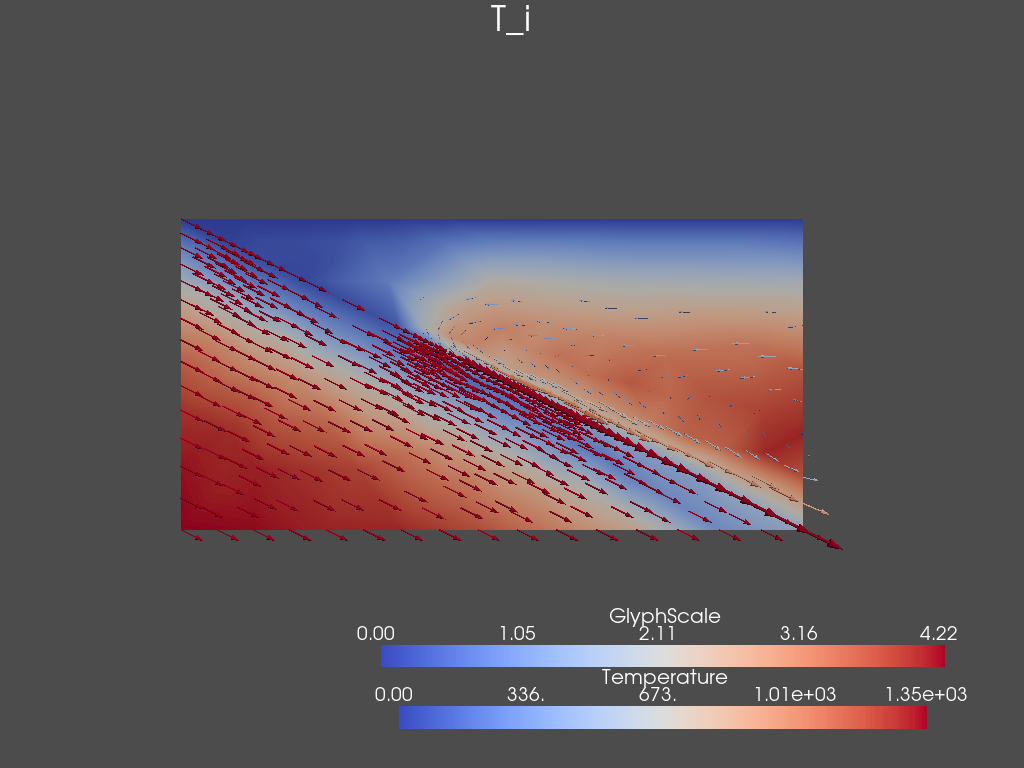

In [67]:
import pyvista
from dolfinx.plot import create_vtk_mesh


glyphs = glyphs_s+glyphsw

pyvista_cells, cell_types, geometry = create_vtk_mesh(Vt)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["Temperature"] = T_i.x.array
grid.set_active_scalars("Temperature")
plotter = pyvista.Plotter()
plotter.add_text("T_i", position="upper_edge", font_size=14)
plotter.add_mesh(grid, show_edges=False, cmap = 'coolwarm')

plotter.add_mesh(glyphs, cmap='coolwarm')
plotter.view_xy()
if not pyvista.OFF_SCREEN:
     plotter.show()
else:
    glyphs = plotter.screenshot('glyphs.pdf', format='pdf')